# Snake venom classification exercise

In this exercise, we are going to take a look at snake venoms :snake:. Because this is an educational course, we are first going
to examine how we can use vsiualizations and basic machine learning libraries, such as scikit-learn to classify the snake venoms.
Later we are going to use ProteusAI to greatly simplify the workflow and to add additional capabilities.

We will use the UniProt database to fetch snake venom toxin sequences. We will use a custom query to select reviewed snake toxin entries.

**UniProt Query**: `taxonomy_id:8570 AND ( cc_tissue_specificity:venom OR cc_scl_term:SL-0177) AND reviewed:true`

We filtered the data, removing toxins that are hard to group into categories and assigned Function Classes based on the 'Function [CC]' column
using OpenAIs GPT o1 model. This was done to create simple functional labels that we can more easily work with, instead of the lengthy function descriptions.

Pandas is imported to load the data and Matplotlib is used to visualize it. Take a look at the data columns.



In [16]:
import pandas as pd

df = pd.read_csv('Snake_Toxins_with_Function_Classes.csv')
df

,Unnamed: 0,Entry,Entry Name,EC number,Protein names,Sequence,Protein families,Function [CC],Function Class
0,1,A0A0B4U9L8,VMF1_VIPAA,3.4.24.-,Zinc metalloproteinase-disintegrin-like protei...,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s...",FUNCTION: Zinc metalloprotease that has fibrin...,Metalloprotease
1,2,A0A0S4FKT4,VSP1_CRODO,3.4.21.-,Thrombin-like enzyme collinein-1 (SVTLE collin...,VIGGDECNINEHNFLVALYEYWSQSFLCGGTLINGEWVLTAAHCDR...,"Peptidase S1 family, Snake venom subfamily",FUNCTION: Thrombin-like snake venom serine pro...,Serine Protease
2,3,A0A193CHJ5,PA2BC_CROTA,3.1.1.4,Phospholipase A2 crotoxin basic subunit CBc (C...,MRALWIVAVLLVGVEGHLLQFNKMIKFETRKNAIPFYAFYGCYCGW...,"Phospholipase A2 family, Group II subfamily, D...",FUNCTION: Heterodimer CA-CB: Crotoxin is a pot...,Phospholipase
3,4,A0A1Z0YU59,MAMB1_DENAN,NaN,Mambaquaretin-1 (MQ-1) (MQ1) (Upsilon-Da2a),RPSFCNLPVKPGPCNGFFSAFYYSQKTNKCHSFTYGGCKGNANRFS...,Venom Kunitz-type family,FUNCTION: Selectively interacts with vasopress...,Vascular Interaction
4,5,A0A2D0TC04,PDE_NAJAT,3.6.1.-,Venom phosphodiesterase (PDE) (EC 3.6.1.-),LKQSKQPLESCRNRCNETFSEELSYCSCDNKCTERKACCWDYQDIC...,Nucleotide pyrophosphatase/phosphodiesterase f...,FUNCTION: Hydrolyzes ADP with high activity. S...,Hydrolase
...,...,...,...,...,...,...,...,...,...
1732,2395,Q9YGW9,3S12_LATLA,NaN,Short neurotoxin VAN-10,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1733,2396,Q9YGX0,3S14_LATCO,NaN,Short neurotoxin NCA-04,MKTLLLTLVVVTTVCLDLGYTRRCFNQQSSQPKTTKSCPLGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1734,2397,Q9YGX1,3S1ED_LATSE,NaN,Short neurotoxin OKI-Ed,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin
1735,2398,T1DKS4,TCTP_CROHD,NaN,Translationally-controlled tumor protein homol...,MIIYRDCISQDEMFSDIYKITEVANGLCLEVEGKMVSRKEGEIDDA...,TCTP family,"FUNCTION: Venom protein that causes edema, enh...",Vascular Interaction


## Visualizing protein sequences

In machine learning data is represented numerically, frequently in the form of vectors. There are countless different choices to be made 
when representing proteins as vectors, which will be covered in detail in later lectures. Here we are going to start simply by encoding 
sequences as one-hot encoded vectors. This means, that we are going to assign each residue in the sequence with a vector, that is
0 in every position except for a single 1. The position of the one will indicate which amino acid we are dealing with.

For example, the amino acid Alanine (Ala, A) can be represented as having the 1 in the first position, while the amino acid
Cystein (Cys, C) can be represented as having the 1 in the second position. Thus, we will communicate that the two amino acids
are different entities. This method of encoding is known as One-Hot Encoding, or short OHE and commonly used to represent discrete
sequences.

Note, that the only information the machine learning algorithms will have when using this annotation is, that 
the amino acids are different. 

**Question** : What could be a problem when representing amino acids as:

    1. A=1, C=2, D=3, ..., Y=20?
    
    2. Using OHE

We will use numpy to encode the protein sequences as vectors

In [17]:
import numpy as np

def one_hot_encode(seq):
    # Dictionary of standard amino acids
    amino_acids = 'ACDEFGHIKLMNPQRSTVWY'
    aa_to_int = {aa: i for i, aa in enumerate(amino_acids)}

    # Initialize the one-hot encoded matrix
    one_hot = np.zeros((len(seq), len(amino_acids)), dtype=int)

    # Fill the matrix
    for i, aa in enumerate(seq):
        if aa in aa_to_int:
            one_hot[i, aa_to_int[aa]] = 1

    return one_hot

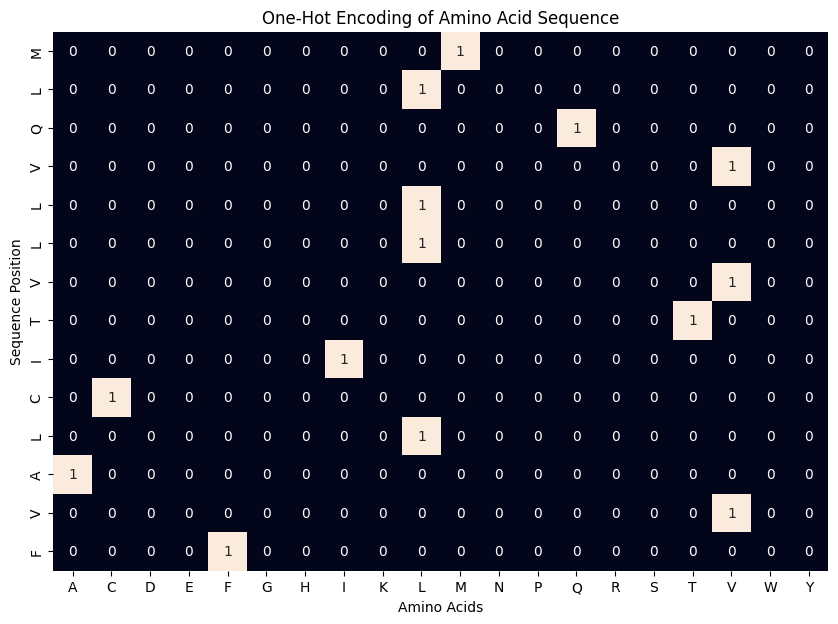

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_one_hot(encoded_seq, seq):
    # Create a heatmap from the one-hot encoded matrix
    plt.figure(figsize=(10, len(encoded_seq) / 2))
    sns.heatmap(encoded_seq, annot=True, cbar=False, cmap='rocket',
                xticklabels=list('ACDEFGHIKLMNPQRSTVWY'), yticklabels=list(seq))
    plt.xlabel('Amino Acids')
    plt.ylabel('Sequence Position')
    plt.title('One-Hot Encoding of Amino Acid Sequence')
    plt.savefig('one_hot_encoding.png')
    plt.show()

# Example usage
seq = "MLQVLLVTICLAVF"
encoded_seq = one_hot_encode(seq)
visualize_one_hot(encoded_seq, seq)

### Now let's encode the entire df

In machine learning it is common to call the input x, thus we are encoding the sequences and give the column the name x.

**Task 1**: 

Create a column 'x' in the dataframe to encode all protein sequences using one-hot encoding.

In [19]:
# encoding all sequences
df['x'] = df['Sequence'].apply(one_hot_encode)
df

,Unnamed: 0,Entry,Entry Name,EC number,Protein names,Sequence,Protein families,Function [CC],Function Class,x
0,1,A0A0B4U9L8,VMF1_VIPAA,3.4.24.-,Zinc metalloproteinase-disintegrin-like protei...,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s...",FUNCTION: Zinc metalloprotease that has fibrin...,Metalloprotease,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1,2,A0A0S4FKT4,VSP1_CRODO,3.4.21.-,Thrombin-like enzyme collinein-1 (SVTLE collin...,VIGGDECNINEHNFLVALYEYWSQSFLCGGTLINGEWVLTAAHCDR...,"Peptidase S1 family, Snake venom subfamily",FUNCTION: Thrombin-like snake venom serine pro...,Serine Protease,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,..."
2,3,A0A193CHJ5,PA2BC_CROTA,3.1.1.4,Phospholipase A2 crotoxin basic subunit CBc (C...,MRALWIVAVLLVGVEGHLLQFNKMIKFETRKNAIPFYAFYGCYCGW...,"Phospholipase A2 family, Group II subfamily, D...",FUNCTION: Heterodimer CA-CB: Crotoxin is a pot...,Phospholipase,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
3,4,A0A1Z0YU59,MAMB1_DENAN,NaN,Mambaquaretin-1 (MQ-1) (MQ1) (Upsilon-Da2a),RPSFCNLPVKPGPCNGFFSAFYYSQKTNKCHSFTYGGCKGNANRFS...,Venom Kunitz-type family,FUNCTION: Selectively interacts with vasopress...,Vascular Interaction,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,..."
4,5,A0A2D0TC04,PDE_NAJAT,3.6.1.-,Venom phosphodiesterase (PDE) (EC 3.6.1.-),LKQSKQPLESCRNRCNETFSEELSYCSCDNKCTERKACCWDYQDIC...,Nucleotide pyrophosphatase/phosphodiesterase f...,FUNCTION: Hydrolyzes ADP with high activity. S...,Hydrolase,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,..."
...,...,...,...,...,...,...,...,...,...,...
1732,2395,Q9YGW9,3S12_LATLA,NaN,Short neurotoxin VAN-10,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1733,2396,Q9YGX0,3S14_LATCO,NaN,Short neurotoxin NCA-04,MKTLLLTLVVVTTVCLDLGYTRRCFNQQSSQPKTTKSCPLGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1734,2397,Q9YGX1,3S1ED_LATSE,NaN,Short neurotoxin OKI-Ed,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."
1735,2398,T1DKS4,TCTP_CROHD,NaN,Translationally-controlled tumor protein homol...,MIIYRDCISQDEMFSDIYKITEVANGLCLEVEGKMVSRKEGEIDDA...,TCTP family,"FUNCTION: Venom protein that causes edema, enh...",Vascular Interaction,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,..."


## Encoding class labels

Next we also need to encode the class labels. These are also going to be encoded using OHe, however, the library we are going to use expects train the classification model
expects simple numbers as class labels and does the OHE under the hood. Because of this we are going to encode the classes as numbers. The output variable (class in this case), 
is often called y. Thus we are calling the encoded class labels y.

**Task 2**: 

Create a column 'y' in the dataframe, assigning unique integer values to individual function classes:

In [20]:
# encode Function Class column as integers
df['y'], unique = pd.factorize(df['Function Class'])
df

,Unnamed: 0,Entry,Entry Name,EC number,Protein names,Sequence,Protein families,Function [CC],Function Class,x,y
0,1,A0A0B4U9L8,VMF1_VIPAA,3.4.24.-,Zinc metalloproteinase-disintegrin-like protei...,MLQVLLVTICLAVFPYQGSSIILESGNVNDYEVVYPQKLTALLKGA...,"Venom metalloproteinase (M12B) family, P-III s...",FUNCTION: Zinc metalloprotease that has fibrin...,Metalloprotease,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",0
1,2,A0A0S4FKT4,VSP1_CRODO,3.4.21.-,Thrombin-like enzyme collinein-1 (SVTLE collin...,VIGGDECNINEHNFLVALYEYWSQSFLCGGTLINGEWVLTAAHCDR...,"Peptidase S1 family, Snake venom subfamily",FUNCTION: Thrombin-like snake venom serine pro...,Serine Protease,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",1
2,3,A0A193CHJ5,PA2BC_CROTA,3.1.1.4,Phospholipase A2 crotoxin basic subunit CBc (C...,MRALWIVAVLLVGVEGHLLQFNKMIKFETRKNAIPFYAFYGCYCGW...,"Phospholipase A2 family, Group II subfamily, D...",FUNCTION: Heterodimer CA-CB: Crotoxin is a pot...,Phospholipase,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",2
3,4,A0A1Z0YU59,MAMB1_DENAN,NaN,Mambaquaretin-1 (MQ-1) (MQ1) (Upsilon-Da2a),RPSFCNLPVKPGPCNGFFSAFYYSQKTNKCHSFTYGGCKGNANRFS...,Venom Kunitz-type family,FUNCTION: Selectively interacts with vasopress...,Vascular Interaction,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,...",3
4,5,A0A2D0TC04,PDE_NAJAT,3.6.1.-,Venom phosphodiesterase (PDE) (EC 3.6.1.-),LKQSKQPLESCRNRCNETFSEELSYCSCDNKCTERKACCWDYQDIC...,Nucleotide pyrophosphatase/phosphodiesterase f...,FUNCTION: Hydrolyzes ADP with high activity. S...,Hydrolase,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,...",4
...,...,...,...,...,...,...,...,...,...,...,...
1732,2395,Q9YGW9,3S12_LATLA,NaN,Short neurotoxin VAN-10,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",5
1733,2396,Q9YGX0,3S14_LATCO,NaN,Short neurotoxin NCA-04,MKTLLLTLVVVTTVCLDLGYTRRCFNQQSSQPKTTKSCPLGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",5
1734,2397,Q9YGX1,3S1ED_LATSE,NaN,Short neurotoxin OKI-Ed,MKTLLLTLVVVTIVCLDLGYTRRCFNQQSSEPQTNKSCPPGENSCY...,"Snake three-finger toxin family, Short-chain s...",FUNCTION: Binds to muscle nicotinic acetylchol...,Neurotoxin,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",5
1735,2398,T1DKS4,TCTP_CROHD,NaN,Translationally-controlled tumor protein homol...,MIIYRDCISQDEMFSDIYKITEVANGLCLEVEGKMVSRKEGEIDDA...,TCTP family,"FUNCTION: Venom protein that causes edema, enh...",Vascular Interaction,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,...",3


## Training the classification model using scikit-learn

Next, we are going to train machine learning models using scikit-learn to classify snake toxins based on.

**Task 3**:

    3.1 Load the dataset into variables X (features) and y (labels).
    3.2 Explore the structure of X. Are all sequences in X the same size? If not, figure out how to handle this.
    3.3 Divide the dataset into training and testing sets.
    3.4 Pick a classifier from the following options:
        a. Logistic Regression
        b. Random Forest
        c. Support Vector Machine
    3.5 Make predictions
    3.6 Evaluate the model with appropriate metrics and interpret the results
    

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
import numpy as np

# Manual padding function
def pad_and_flatten(sequences):
    """
    Pad sequences to the same length and flatten them
    """
    max_len = max(seq.shape[0] for seq in sequences)
    
    # padd sequences
    padded_sequences = []
    for seq in sequences:
        pad_size = max_len - seq.shape[0]
        padded_seq = np.pad(seq, ((0, pad_size), (0, 0)), mode='constant', constant_values=0)
        flattened_seq = padded_seq.reshape(-1)
        padded_sequences.append(flattened_seq)

    return np.array(padded_sequences)

# Load X and y
X = df['x'].to_list()
y = df['y']

# Apply padding
X_padded = pad_and_flatten(X)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_padded, y, test_size=0.2, random_state=42)

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42)

# Train the model
rf_model.fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Print results
print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)


Accuracy: 0.7931034482758621
Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.81      0.67        27
           1       0.97      0.92      0.94        62
           2       0.91      0.96      0.93        82
           3       0.60      0.63      0.62        19
           4       1.00      1.00      1.00         1
           5       0.93      0.91      0.92        58
           6       0.33      0.24      0.28        25
           7       0.74      0.67      0.70        21
           8       0.68      0.68      0.68        34
           9       0.00      0.00      0.00         1
          10       0.64      0.50      0.56        18

    accuracy                           0.79       348
   macro avg       0.67      0.67      0.66       348
weighted avg       0.79      0.79      0.79       348



/home/jonfunk/miniforge3/envs/proteusAI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonfunk/miniforge3/envs/proteusAI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/jonfunk/miniforge3/envs/proteusAI/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_

## Visualizing results

Now that we have trained the model we would like to visualize the results, which is an important step to communicate the capabilities of your model, but its also interesting for you to quickly see where your model performs better or worse. Visualize your results using a confusion matrix.

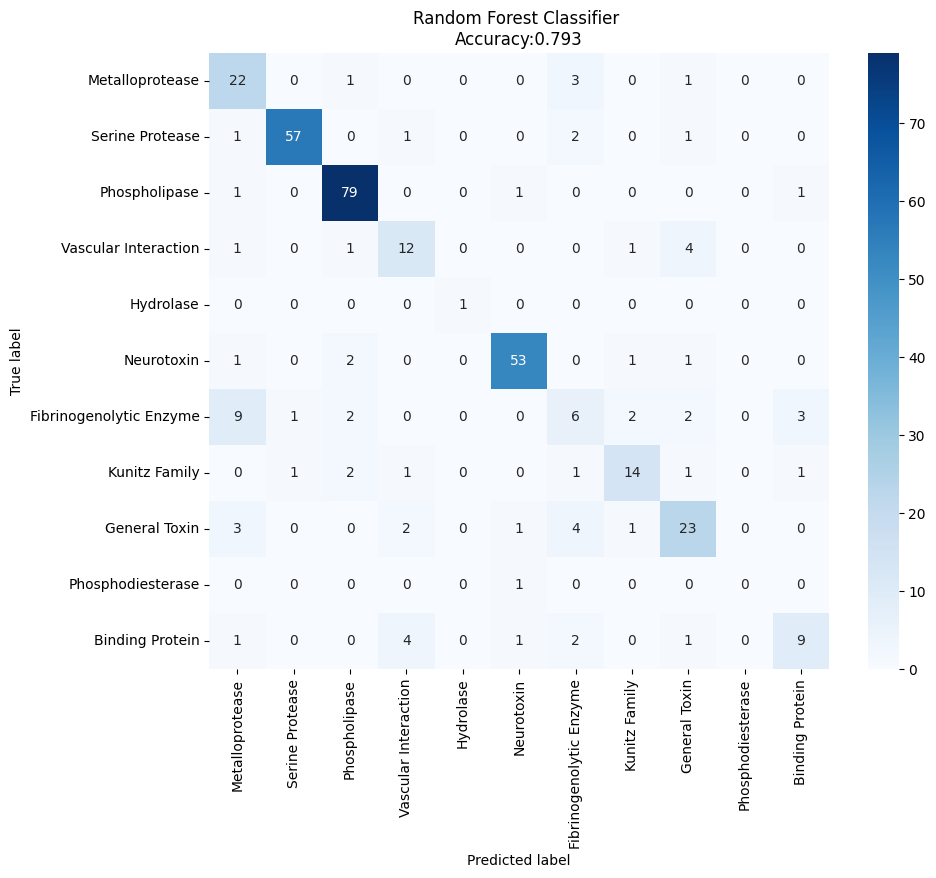

In [32]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Create a DataFrame for better visualization
cm_df = pd.DataFrame(cm, index=unique, columns=unique)

# Create the plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')   
plt.title('Random Forest Classifier \nAccuracy:{0:.3f}'.format(accuracy))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.savefig('confusion_matrix.png')
plt.show()

# ProteusAI

Now lets do the same thing with the library ´ProteusAI´ which automates a lot of the tideous steps and gets you from training to results in only a few lines of code.

In [33]:
import proteusAI as pai

In [34]:
lib = pai.Library(
    source="Snake_Toxins_with_Function_Classes.csv",
    names_col="Entry Name",
    seqs_col="Sequence",
    y_col="Function Class",
    y_type="class"
)

In [35]:
lib.compute("esm2_8M", device="cpu", batch_size=100)

computing 0 proteins


In [36]:
fig, ax, df = lib.plot(method="tsne", rep="esm2_8M")

plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.0))
plt.savefig("tsne.png")

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1737 samples in 0.001s...
[t-SNE] Computed neighbors for 1737 samples in 0.136s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1737
[t-SNE] Computed conditional probabilities for sample 1737 / 1737
[t-SNE] Mean sigma: 0.408704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.739620
[t-SNE] KL divergence after 1000 iterations: 0.455098


/home/jonfunk/ProteusAI/src/proteusAI/visual_tools/plots.py:172: UserWarning: 
The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(


In [41]:
fig, ax, df = lib.plot(method="tsne", rep="esm2_8M")

plt.savefig("tsne.png")
plt.show()

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1737 samples in 0.001s...
[t-SNE] Computed neighbors for 1737 samples in 0.047s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1737
[t-SNE] Computed conditional probabilities for sample 1737 / 1737
[t-SNE] Mean sigma: 0.408704
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.739616
[t-SNE] KL divergence after 1000 iterations: 0.455098


/home/jonfunk/ProteusAI/src/proteusAI/visual_tools/plots.py:172: UserWarning: 
The palette list has fewer values (8) than needed (11) and will cycle, which may produce an uninterpretable plot.
  scatter = sns.scatterplot(


In [38]:
model = pai.Model(
    model_type="rf", 
    library=lib,
    x="esm2_8M",
    seed=42,
)

/home/jonfunk/ProteusAI/src/proteusAI/Model/model.py:144: FutureWarning: 'x' is deprecated and will be removed in a future version. Please use 'rep' instead.
  setattr(self, key, value)


In [39]:
model.train()

Training completed:
val_r2:	0.8285714285714286
val_pearson:	PearsonRResult(statistic=0.8409409162354097, pvalue=5.2150389452296296e-48)


{'df':              name                                           sequence  y_true  \
 0      VNPD_PSEAU            SGSKTAEIDDGCFGLPLDPIGSTSGMGCRSVPKPIPGGS       2   
 1      3NBB_COERA  QAIGPPYGLCFQCNQKTSSDCTEARRCSPFHEKCYTLYQPDENWMK...       6   
 2      VKT7_DEMVE  MSSGGLLLLLGLLTLWAELTPVSSKDRPEICKLPKEPGPCRSYLLY...       9   
 3     PA2B1_MICMP  NLIHFSSMIKCTIPGSKPVPDYSDYGCYCGKGGSGTPVDALDRCCQ...       8   
 4      VSP1_BUNMU  MVLIGVLASLLILQLSYSKSLDDGAKESAYDDEIQQSSWGNSTVNT...       9   
 ...           ...                                                ...     ...   
 1732  PA2H2_BOTBZ  SLFELGKMILQETGKNPAKSYGAYGCYCGVLGRGKPKDATDRCCYV...       8   
 1733    CYT_PSEAU  MVHSQLPVAGPLRLLCALLLLPSATMIPGGLSPRSVTDPDVQEAAE...       2   
 1734   OXLA_DABRR  MNVFFMFSLLFLATLGSCADDKNPLEECFREDDYEEFLEIAKNGLK...       4   
 1735  VM1LA_BOTLC  QQFSPRYIELVVVADHGMFKKYNSNLNTIRKWVHEMLNTVNGFFRS...       1   
 1736  SLLC2_VIPAP                                      AFCCPSGWSAYDQ       5   
 
       y_predicted y

In [ ]:
# Plot confusion matrix (implement in ProteusAI)